Adversarial attacks! This is taken from Kolter/Madry's ICML tutorial.


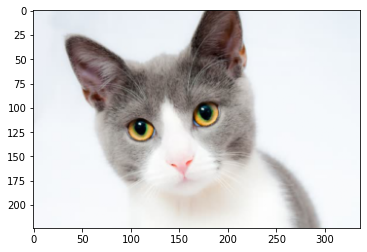

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import io
import requests
from PIL import Image
from torchvision import models, transforms

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://s3.amazonaws.com/outcome-blog/wp-content/uploads/2017/02/25192225/cat.jpg'

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
img_tensor = preprocess(img_pil)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(img_tensor[0].numpy().transpose(1,2,0));


In [0]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [21]:
pred = model(norm(img_tensor))
import json
LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'
imagenet_classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

Egyptian cat


This works! Now let's try to adversarially attack this model.

In [22]:
# class index
print(pred.max(dim=1)[1].item())
print(nn.Softmax(dim=1)(pred)[0,285].item())

285
0.4118555188179016


The way to do so is to perform gradient descent *over the input* so as to *maximize* the cross entropy with respect to the correct logit. 

In [23]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(img_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([285]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,285].item())

0 -0.8870826959609985
5 -15.292627334594727
10 -17.973102569580078
15 -19.66139793395996
20 -15.540562629699707
25 -19.84621238708496
True class probability: 8.326184186557839e-10


OK, so true softmax logit has been completely squashed. What does the network think it is?

In [24]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  Persian cat
Predicted probability: 0.9999817609786987


OK, not a big deal! We changed classes but to another cat. How about make it particularly nefarious? Pick a random class (say an airliner).

In [25]:
delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(30):
    pred = model(norm(img_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([285])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 11.296475410461426
10 -2.2717082500457764
20 -11.24067211151123


In [26]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9630945920944214


OK, but is the image any different really?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


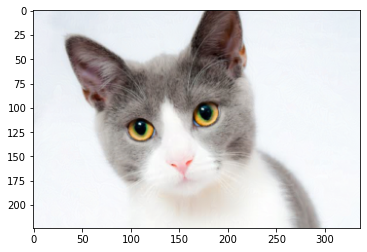

In [27]:
plt.imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Looks (virtually) identical to the original. Here is the noise we added:

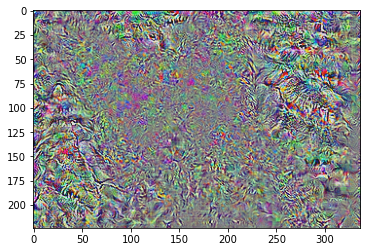

In [28]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))